# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [1]:
import csv
import math
import scipy
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle

# Visualizations will be shown in the notebook.
%matplotlib inline

---
## Step 0: Load The Data

In [2]:
# Load pickled data
training_file = 'data/traffic-signs-data/train.p'
validation_file= 'data/traffic-signs-data/valid.p'
testing_file = 'data/traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_raw, y_train_raw = train['features'], train['labels']
X_valid_raw, y_valid_raw = valid['features'], valid['labels']
X_test_raw, y_test_raw = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
n_train_raw = len(X_train_raw)
n_validation_raw = len(X_valid_raw)
n_test_raw = len(X_test_raw)

image_shape = np.array(X_train_raw).shape[1:4]
n_classes = len(np.unique(y_train_raw))

print("Number of original training examples =", n_train_raw)
print("Number of original testing examples =", n_test_raw)
print("Number of original validation examples =", n_validation_raw)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of original training examples = 34799
Number of original testing examples = 12630
Number of original validation examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

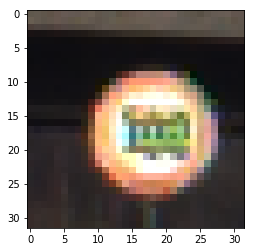

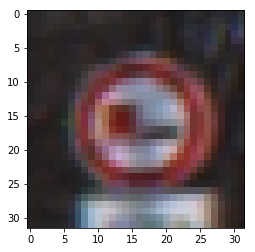

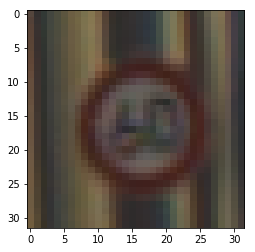

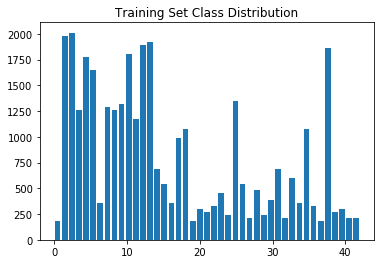

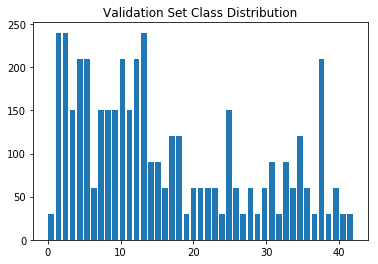

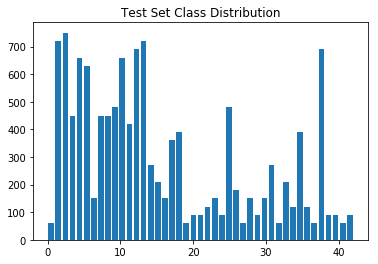

In [4]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.

# draw some traffic sign images
def draw_random_image(x, total_number, num_random_images=1):
    for index in range(num_random_images):
        randomSelection = np.random.randint(0, total_number)
        image = x[randomSelection]
        plt.imshow(image)
        plt.show()

def draw_classes_distribution(labels, num_classes, title):
    label_values = np.arange(0, num_classes)
    label_counts = np.bincount(labels)
    total_labels = np.sum(label_counts)
    plt.hist(labels,n_classes, rwidth=0.8)
    plt.title(title)
    plt.show()
        
draw_random_image(X_train_raw, n_train_raw)
draw_random_image(X_valid_raw, n_validation_raw)
draw_random_image(X_test_raw, n_test_raw)

draw_classes_distribution(y_train_raw, n_classes, 'Training Set Class Distribution')
draw_classes_distribution(y_valid_raw, n_classes, 'Validation Set Class Distribution')
draw_classes_distribution(y_test_raw, n_classes, 'Test Set Class Distribution')

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [5]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

def normalize(X):
    return (X - 128.0) / 128.0


def rgb_to_grayscale(X):
    return np.dot(X[...,:3], [0.299, 0.587, 0.114])


def preprocess(X):
    X = rgb_to_grayscale(X)
    X = np.expand_dims(X, axis=3)
    return normalize(X)


def random_translate_jittering(image):
    rows, cols, channels = image.shape
    translate_x = np.random.uniform(-2, 2)
    translate_y = np.random.uniform(-2, 2)
    translation_matrix = np.array([[1.0, 0.0, translate_x], [0.0, 1.0, translate_y]], dtype=float)
    return cv2.warpAffine(image, translation_matrix, (cols, rows))


def random_rotate_jittering(image):
    rows, cols, channels = image.shape
    rotation_angle = np.random.uniform(-15.0, 15.0)
    rotation_matrix = cv2.getRotationMatrix2D((cols/2, rows/2), rotation_angle, 1)
    return cv2.warpAffine(image, rotation_matrix, (cols, rows))


def random_shear_jittering(image):
    rows, cols, channels = image.shape
    shear_range = 5.0
    shear_src = np.array([[5,5],[20,5],[5,20]], dtype=np.float32)
    pt1 = 5 + shear_range*np.random.uniform() - shear_range/2
    pt2 = 20 + shear_range*np.random.uniform() - shear_range/2
    shear_dst = np.array([[pt1, 5],[pt2, pt1],[5, pt2]], dtype=np.float32)
    sheer_matrix = cv2.getAffineTransform(shear_src, shear_dst)
    return cv2.warpAffine(image, sheer_matrix, (cols, rows))


def augment_image(image):
    result = random_rotate_jittering(image)
    result = random_translate_jittering(result)
    result = random_shear_jittering(result)
    return result


'''
make the training set balanced by generating more jittered images
here we generate 2*max_number_of_labels for all classes
'''
def balance_dataset_by_augmentation(x, y):
    n_classes = len(np.unique(y))
    label_values = np.arange(0, n_classes)
    label_counts = np.bincount(y)
    
    # set the target count to be 2*max_count_of_labels
    target_count = 2 * np.amax(label_counts)
    
    # generate augmented data and put into new list
    augmented_x = []
    augmented_y = []
    for label in label_values:
        print("Generating augmented data for label {} ...".format(label))
        label_count = label_counts[label]
        samples_to_generate = target_count - label_count

        # get the indices of all samples with the same label
        indices = np.where(y==label)[0]
        for i in range(samples_to_generate):
            random_selection = np.random.randint(0, label_count)
            random_features = x[indices[random_selection]]
            new_features = augment_image(random_features)
            augmented_x.append(new_features)
            augmented_y.append(label)
    
    # merge the generated data and existing data
    result_x = np.append(x, augmented_x, axis=0)
    result_y = np.append(y, augmented_y, axis=0)
    return result_x, result_y

Start preprocessing training set ...
Generating augmented data for label 0 ...
Generating augmented data for label 1 ...
Generating augmented data for label 2 ...
Generating augmented data for label 3 ...
Generating augmented data for label 4 ...
Generating augmented data for label 5 ...
Generating augmented data for label 6 ...
Generating augmented data for label 7 ...
Generating augmented data for label 8 ...
Generating augmented data for label 9 ...
Generating augmented data for label 10 ...
Generating augmented data for label 11 ...
Generating augmented data for label 12 ...
Generating augmented data for label 13 ...
Generating augmented data for label 14 ...
Generating augmented data for label 15 ...
Generating augmented data for label 16 ...
Generating augmented data for label 17 ...
Generating augmented data for label 18 ...
Generating augmented data for label 19 ...
Generating augmented data for label 20 ...
Generating augmented data for label 21 ...
Generating augmented data f

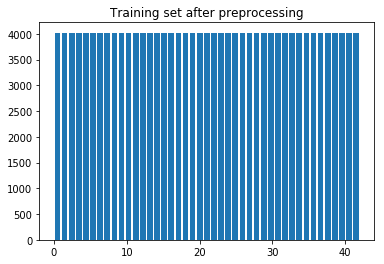

In [6]:
print('Start preprocessing training set ...')
X_train, y_train = balance_dataset_by_augmentation(X_train_raw, y_train_raw)
X_train = preprocess(X_train)

print('Start preprocessing valid set ...')
X_valid = preprocess(X_valid_raw)
y_valid = y_valid_raw

print('Start preprocessing test set ...')
X_test = preprocess(X_test_raw)
y_test = y_test_raw

n_channels = np.array(X_train).shape[3]

print('Num Channels is: {}'.format(n_channels))
print('Training Set after preprocessing is: {}'.format(np.array(X_train).shape))
print('Validation Set after preprocessing is: {}'.format(np.array(X_valid).shape))
print('Test Set after preprocessing is: {}'.format(np.array(X_test).shape))
print('Training set data distribution is:')

draw_classes_distribution(y_train, n_classes, 'Training set after preprocessing')

### Model Architecture

In [7]:
# LeNet as defined in class, dropout is added for regularization
def LeNet(x, keep_prob, n_channels, n_classes):
    layers = {}

    # arguments used for tf.truncated_normal
    mu = 0
    sigma = 0.1

    # layer 1: convolution 32*32*n_channels ->28*28*6
    conv1_weight = tf.Variable(tf.truncated_normal(shape=[5,5,n_channels,6], mean=mu, stddev=sigma), name='conv1_weight')
    conv1_bias = tf.Variable(tf.zeros(6), name='conv1_bias')
    conv1 = tf.nn.conv2d(x, conv1_weight, strides=[1,1,1,1], padding='VALID') + conv1_bias
    conv1 = tf.nn.relu(conv1)
    layers['conv1'] = conv1

    # layer 1: pooling 28*28*6 -> 14*14*6
    conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    conv1 = tf.nn.dropout(conv1, keep_prob=keep_prob)

    # layer 2: convolution 14*14*6 -> 10*10*16
    conv2_weight = tf.Variable(tf.truncated_normal(shape=[5,5,6,16], mean=mu, stddev=sigma), name='conv2_weight')
    conv2_bias = tf.Variable(tf.zeros(16), name='conv2_bias')
    conv2 = tf.nn.conv2d(conv1, conv2_weight, strides=[1,1,1,1], padding='VALID') + conv2_bias
    conv2 = tf.nn.relu(conv2)
    layers['conv2'] = conv2

    # layer 2: pooling 10*10*16 -> 5*5*16
    conv2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    conv2 = tf.nn.dropout(conv2, keep_prob=keep_prob)

    # layer 2: flatten 5*5*16 -> 400
    conv2 = flatten(conv2)

    # layer 3: fully connected 400 ->120
    fc1_weight = tf.Variable(tf.truncated_normal(shape=[400, 120], mean=mu, stddev=sigma), name='fc1_weight')
    fc1_bias = tf.Variable(tf.zeros(120), name='fc1_bias')
    fc1 = tf.matmul(conv2, fc1_weight) + fc1_bias

    # layer 3: activation
    fc1 = tf.nn.relu(fc1)

    # layer 3: dropout
    fc1 = tf.nn.dropout(fc1, keep_prob=keep_prob)

    # layer 4: fully connected 120 -> 84
    fc2_weight = tf.Variable(tf.truncated_normal(shape=[120, 84], mean=mu, stddev=sigma), name='fc2_weight')
    fc2_bias = tf.Variable(tf.zeros(84), name='fc2_bias')
    fc2 = tf.matmul(fc1, fc2_weight) + fc2_bias

    # layer 4: activation
    fc2 = tf.nn.relu(fc2)

    # layer 4: dropout
    fc2 = tf.nn.dropout(fc2, keep_prob=keep_prob)

    # layer 5: fully connected 84 -> n_classes
    out_weight = tf.Variable(tf.truncated_normal(shape=[84, n_classes], mean=mu, stddev=sigma), name='out_weight')
    out_bias = tf.Variable(tf.zeros(n_classes), name='out_bias')
    logits = tf.matmul(fc2, out_weight) + out_bias

    return logits, layers


# a multi scale net
def MultiScaleNet(x, keep_prob, n_channels, n_classes):
    layers = {}
    # arguments used for tf.truncated_normal
    mu = 0
    sigma = 0.1

    # layer 1: conv 32*32*n_channels -> 32*32*32
    conv1_weight = tf.Variable(tf.truncated_normal(shape=[5,5,n_channels,32], mean=mu, stddev=sigma))
    conv1_bias = tf.Variable(tf.zeros(32))
    conv1 = tf.nn.conv2d(x, conv1_weight, strides=[1,1,1,1], padding='SAME') + conv1_bias
    conv1 = tf.nn.relu(conv1)
    layers['conv1'] = conv1

    # layer 2: max pooling 32*32*32 -> 16*16*32
    conv1 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    conv1 = tf.nn.dropout(conv1, keep_prob=keep_prob)

    # layer 3: conv 16*16*32 -> 16*16*64
    conv2_weight = tf.Variable(tf.truncated_normal(shape=[5,5,32,64], mean=mu, stddev=sigma))
    conv2_bias = tf.Variable(tf.zeros(64))
    conv2 = tf.nn.conv2d(conv1, conv2_weight, strides=[1,1,1,1], padding='SAME') + conv2_bias
    conv2 = tf.nn.relu(conv2)
    layers['conv2'] = conv2

    # layer 4: max pooling 16*16*64 -> 8*8*64
    conv2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    conv2 = tf.nn.dropout(conv2, keep_prob=keep_prob)

    # layer 5: conv 8*8*64 -> 8*8*128
    conv3_weight = tf.Variable(tf.truncated_normal(shape=[5,5,64,128], mean=mu, stddev=sigma))
    conv3_bias = tf.Variable(tf.zeros(128))
    conv3 = tf.nn.conv2d(conv2, conv3_weight, strides=[1,1,1,1], padding='SAME') + conv3_bias
    conv3 = tf.nn.relu(conv3)
    layers['conv3'] = conv3

    # layer 6: max pooling 8*8*128 -> 4*4*128
    conv3 = tf.nn.max_pool(conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    conv3 = tf.nn.dropout(conv3, keep_prob=keep_prob)

    # layer 7: fully connected 3584 -> 1024
    conv1_max_pool = tf.nn.max_pool(conv1, ksize=[1,4,4,1], strides=[1,4,4,1], padding='VALID')
    conv1_flatten = flatten(conv1_max_pool)
    conv2_max_pool = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    conv2_flatten = flatten(conv2_max_pool)
    conv3_flatten = flatten(conv3)

    fc1_input = tf.concat([conv1_flatten, conv2_flatten, conv3_flatten], axis=1)

    fc1_weight = tf.Variable(tf.truncated_normal(shape=[3584,1024], mean=mu, stddev=sigma))
    fc1_bias = tf.Variable(tf.zeros(1024))
    fc1 = tf.matmul(fc1_input, fc1_weight) + fc1_bias
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob=keep_prob)

    # layer 8 : fully connected 1024 -> n_classes
    fc2_weight = tf.Variable(tf.truncated_normal(shape=[1024,n_classes], mean=mu, stddev=sigma))
    fc2_bias = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc1, fc2_weight) + fc2_bias

    return logits, layers


# a much deeper network
def DeepNet(x, keep_prob, n_channels, n_classes):
    layers = {}

    # arguments used for tf.truncated_normal
    mu = 0
    sigma = 0.1

    # layer 1: Conv 32*32*n_channels -> 32*32*32
    conv1_weight = tf.Variable(tf.truncated_normal(shape=[3,3,n_channels,32], mean=mu, stddev=sigma, name='con1_weight'))
    conv1_bias = tf.Variable(tf.zeros(32), name='con1_bias')
    conv1 = tf.nn.conv2d(x, conv1_weight, strides=[1,1,1,1], padding='SAME') + conv1_bias
    conv1 = tf.nn.relu(conv1)
    layers['conv1'] = conv1

    # layer 2: Conv 32*32*32 -> 30*30*32
    conv2_weight = tf.Variable(tf.truncated_normal(shape=[3,3,32,32], mean=mu, stddev=sigma), name='conv2_weight')
    conv2_bias = tf.Variable(tf.zeros(32), name='conv2_bias')
    conv2 = tf.nn.conv2d(conv1, conv2_weight, strides=[1,1,1,1], padding='VALID') + conv2_bias
    conv2 = tf.nn.relu(conv2)
    layers['conv2'] = conv2

    # layer 2: pooling 30*30*32 -> 15*15*32 and dropout
    conv2 = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    conv2 = tf.nn.dropout(conv2, keep_prob=keep_prob)

    # layer 3: conv 15*15*32 -> 15*15*64
    conv3_weight = tf.Variable(tf.truncated_normal(shape=[3,3,32,64], mean=mu, stddev=sigma), name='conv3_weight')
    conv3_bias = tf.Variable(tf.zeros(64), name='conv3_bias')
    conv3 = tf.nn.conv2d(conv2, conv3_weight, strides=[1,1,1,1], padding='SAME') + conv3_bias
    conv3 = tf.nn.relu(conv3)
    layers['conv3'] = conv3

    # layer 4: conv 15*15*64 -> 13*13*64
    conv4_weight = tf.Variable(tf.truncated_normal(shape=[3,3,64,64], mean=mu, stddev=sigma), name='conv4_weight')
    conv4_bias = tf.Variable(tf.zeros(64), name='conv4_bias')
    conv4 = tf.nn.conv2d(conv3, conv4_weight, strides=[1,1,1,1], padding='VALID') + conv4_bias
    conv4 = tf.nn.relu(conv4)
    layers['conv4'] = conv4

    # layer 4: pooling 13*13*64 -> 6*6*64
    conv4 = tf.nn.max_pool(conv4, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    conv4 = tf.nn.dropout(conv4, keep_prob=keep_prob)

    # layer 5: 6*6*64 -> 6*6*128
    conv5_weight = tf.Variable(tf.truncated_normal(shape=[3,3,64,128], mean=mu, stddev=sigma), name='conv5_weight')
    conv5_bias = tf.Variable(tf.zeros(128), name='conv5_bias')
    conv5 = tf.nn.conv2d(conv4, conv5_weight, strides=[1,1,1,1], padding='SAME') + conv5_bias
    conv5 = tf.nn.relu(conv5)
    layers['conv5'] = conv5

    # layer 6: 6*6*128 -> 4*4*128
    conv6_weight = tf.Variable(tf.truncated_normal(shape=[3,3,128,128], mean=mu, stddev=sigma), name='conv6_weight')
    conv6_bias = tf.Variable(tf.zeros(128), name='conv6_bias')
    conv6 = tf.nn.conv2d(conv5, conv6_weight, strides=[1,1,1,1], padding='VALID') + conv6_bias
    conv6 = tf.nn.relu(conv6)
    layers['conv6'] = conv6

    # layer 6: pooling 4*4*128 -> 2*2*128
    conv6 = tf.nn.max_pool(conv6, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    conv6 = tf.nn.dropout(conv6, keep_prob=keep_prob)

    # layer 6: flatten  2*2*128 -> 512
    conv6 = flatten(conv6)

    # layer 7: fully connected 512 -> 512
    fc1_weight = tf.Variable(tf.truncated_normal(shape=[512,512], mean=mu, stddev=sigma), name='fc1_weight')
    fc1_bias = tf.Variable(tf.zeros(512), name='fc1_bias')
    fc1 = tf.matmul(conv6, fc1_weight) + fc1_bias
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob=keep_prob)

    # layer 8: fully connected 512 -> n_classes
    out_weight = tf.Variable(tf.truncated_normal(shape=[512,n_classes], mean=mu, stddev=sigma), name='out_weight')
    out_bias = tf.Variable(tf.zeros(n_classes), name='out_bias')
    logits = tf.matmul(fc1, out_weight) + out_bias

    return logits, layers

In [8]:
class Model:
    EPOCHS = 30
    BATCH_SIZE = 128
    START_LEARNING_RATE = 0.0005
    TRAIN_KEEP_RATE= 0.8

    def __init__(self, n_channels, n_classes):
        self.x = tf.placeholder(tf.float32, shape=[None, 32, 32, n_channels])
        self.y = tf.placeholder(tf.int32, shape=[None])
        self.global_step = tf.Variable(0, trainable=False, name='global_step')
        self.learning_rate = tf.train.exponential_decay(Model.START_LEARNING_RATE, self.global_step, 5000, 0.96, staircase=True)
        self.keep_prob = tf.placeholder(tf.float32)

        #logits, self.nn_layers = LeNet(self.x, self.keep_prob, n_channels, n_classes)
        #logits, self.nn_layers = MultiScaleNet(self.x, self.keep_prob, n_channels, n_classes)
        logits, self.nn_layers = DeepNet(self.x, self.keep_prob, n_channels, n_classes)
        labels = tf.one_hot(self.y, n_classes)

        self.train_operation = self.get_train_operation(logits, labels)
        self.accuracy_operation = self.get_accuracy_operation(logits, labels)
        self.predict_operation = self.get_predict_operation(logits)
        self.predict_top5_operation = self.get_predict_top5_operation(logits)

    def print_model_info(self):
        print('Start training with BATCH_SIZE:{} EPOCH:{} Start Learning Rate:{}, KEEP_PROB:{}'.format(
            Model.BATCH_SIZE,
            Model.EPOCHS,
            Model.START_LEARNING_RATE,
            Model.TRAIN_KEEP_RATE))

    def get_train_operation(self, logits, labels):
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels)
        loss = tf.reduce_mean(cross_entropy)
        optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        train_operation = optimizer.minimize(loss, global_step=self.global_step)
        return train_operation

    def get_accuracy_operation(self, logits, labels):
        correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
        accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        return accuracy_operation

    def get_predict_operation(self, logits):
        predict_operation = tf.argmax(logits, 1)
        return predict_operation

    def get_predict_top5_operation(self, logits):
        softmax = tf.nn.softmax(logits)
        predict_top5_operation =tf.nn.top_k(softmax, k=5)
        return predict_top5_operation

    def evaluate(self, sess, x, y):
        num_examples = len(x)
        total_accuracy = 0
        for offset in range(0, num_examples, Model.BATCH_SIZE):
            x_batch = x[offset:offset+Model.BATCH_SIZE]
            y_batch = y[offset:offset+Model.BATCH_SIZE]
            accuracy = sess.run(self.accuracy_operation, feed_dict={self.x:x_batch, self.y:y_batch, self.keep_prob:1.0})
            total_accuracy += (accuracy * len(x_batch))
        return total_accuracy / num_examples

    def train_and_save(self, x_train, y_train, x_valid, y_valid, save_file):
        self.print_model_info()
        train_accuracy_history = []
        valid_accuracy_history = []
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            num_examples = len(x_train)
            for i in range(Model.EPOCHS):
                x_train_epoch, y_train_epoch = shuffle(x_train, y_train)
                for offset in range(0, num_examples, Model.BATCH_SIZE):
                    x_batch = x_train_epoch[offset:offset+Model.BATCH_SIZE]
                    y_batch = y_train_epoch[offset:offset+Model.BATCH_SIZE]
                    sess.run(self.train_operation, feed_dict={self.x:x_batch, self.y:y_batch, self.keep_prob:Model.TRAIN_KEEP_RATE})

                train_accuracy = self.evaluate(sess, x_train, y_train)
                train_accuracy_history.append(train_accuracy)
                
                valid_accuracy = self.evaluate(sess, x_valid, y_valid)
                valid_accuracy_history.append(valid_accuracy)
                print('EPOCH {}, train accuracy = {:.3f}, valid accuracy = {:.3f}, learning rate={:.6f}'.format(
                    i+1, train_accuracy, valid_accuracy, sess.run(self.learning_rate)))

            print('Train accuracy = {:.3f}, valid accuracy={:.3f}'.format(train_accuracy, valid_accuracy))
            self.save(sess, save_file)
        
        self.draw_train_and_valid_accuracy_history(train_accuracy_history, valid_accuracy_history)
        
    def draw_train_and_valid_accuracy_history(self, train_accuracy_history, valid_accuracy_history):
        epoches = range(1, Model.EPOCHS + 1)
            
        plt.figure()
        plt.title('Test and Valid accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.grid()
        plt.plot(epoches, train_accuracy_history, 'o-', label='training accuracy')
        plt.plot(epoches, valid_accuracy_history, 'o-', label='valid accuracy')
        plt.legend(loc='best')
        plt.show()
        
    def load_and_test(self, x_test, y_test, file_path):
        self.print_model_info()
        saver = tf.train.Saver()
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            saver.restore(sess, file_path)
            test_accuracy = self.evaluate(sess, x_test, y_test)
            print('Test Accuracy is {:.3f}'.format(test_accuracy))

    def load_and_predict(self, images, file_path):
        saver = tf.train.Saver()
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            saver.restore(sess, file_path)
            prediction = sess.run(self.predict_operation, feed_dict={self.x:images, self.keep_prob:1.0})
            return prediction

    def load_and_predict_top5(self, images, file_path):
        saver = tf.train.Saver()
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            saver.restore(sess, file_path)
            prediction = sess.run(self.predict_top5_operation, feed_dict={self.x:images, self.keep_prob:1.0})
            return prediction

    def load_and_visualize(self, image, file_path, layer_name):
        saver = tf.train.Saver()
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            saver.restore(sess, file_path)
            self.output_feature_map(sess, image, self.nn_layers[layer_name])

    def output_feature_map(self, sess, image, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
        activation = sess.run(tf_activation, feed_dict={self.x:image, self.keep_prob:1.0})
        featuremaps = activation.shape[3]
        plt.figure(plt_num, figsize=(15,15))
        num_columns = 8
        num_rows = featuremaps / num_columns
        for featuremap in range(featuremaps):
            plt.subplot(num_rows, num_columns, featuremap+1) # sets the number of feature maps to show on each row and column
            plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
            if activation_min != -1 & activation_max != -1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
            elif activation_max != -1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
            elif activation_min !=-1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
            else:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
        plt.show()

    def save(self, sess, file_path):
        saver = tf.train.Saver()
        saver.save(sess, file_path)
        print('model saved to {}'.format(file_path))

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

Start training with BATCH_SIZE:128 EPOCH:30 Start Learning Rate:0.0005, KEEP_PROB:0.8
EPOCH 1, train accuracy = 0.958, valid accuracy = 0.956, learning rate=0.000500
EPOCH 2, train accuracy = 0.988, valid accuracy = 0.976, learning rate=0.000500
EPOCH 3, train accuracy = 0.994, valid accuracy = 0.985, learning rate=0.000500
EPOCH 4, train accuracy = 0.997, valid accuracy = 0.992, learning rate=0.000480
EPOCH 5, train accuracy = 0.998, valid accuracy = 0.993, learning rate=0.000480
EPOCH 6, train accuracy = 0.999, valid accuracy = 0.990, learning rate=0.000480
EPOCH 7, train accuracy = 0.999, valid accuracy = 0.991, learning rate=0.000480
EPOCH 8, train accuracy = 0.999, valid accuracy = 0.994, learning rate=0.000461
EPOCH 9, train accuracy = 0.999, valid accuracy = 0.994, learning rate=0.000461
EPOCH 10, train accuracy = 0.999, valid accuracy = 0.994, learning rate=0.000461
EPOCH 11, train accuracy = 0.999, valid accuracy = 0.992, learning rate=0.000461
EPOCH 12, train accuracy = 1.000

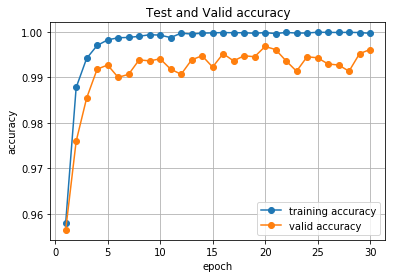

Start training with BATCH_SIZE:128 EPOCH:30 Start Learning Rate:0.0005, KEEP_PROB:0.8
INFO:tensorflow:Restoring parameters from ./result/deepnet
Test Accuracy is 0.984


In [9]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

model_save_file = './result/deepnet'

model = Model(n_channels, n_classes)
model.train_and_save(X_train, y_train, X_valid, y_valid, model_save_file)
model.load_and_test(X_test, y_test, model_save_file)

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

Input Images are as following :


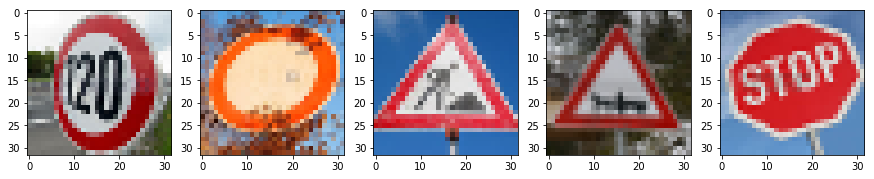

Normalized Input Images are as following :


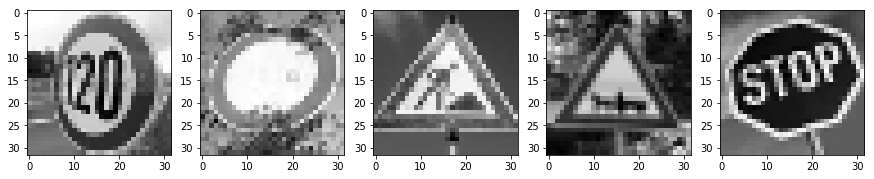

In [10]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
def load_image(image_file_path):
    image = cv2.imread(image_file_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image


def display_input_images(images):
    print('Input Images are as following :')
    num_images = len(images)
    fig, axs = plt.subplots(nrows=1, ncols=num_images, figsize=(15,15))
    index = 0
    for image in images:
        axs[index].imshow(image)
        index += 1
    plt.show()
    
    
def display_normalized_images(images):
    print('Normalized Input Images are as following :')
    num_images = len(images)
    fig, axs = plt.subplots(nrows=1, ncols=num_images,figsize=(15,15))
    index = 0
    for image in images:
        axs[index].imshow(image.squeeze(), cmap='gray')
        index += 1
    plt.show()
        

input_image_files  = []
input_image_files.append('./test_images/120.png')
input_image_files.append('./test_images/no_entry.png')
input_image_files.append('./test_images/construction.png')
input_image_files.append('./test_images/horse_car.png')
input_image_files.append('./test_images/stop.png')

input_images = []
for image_file in input_image_files:
    input_images.append(load_image(image_file))
display_input_images(input_images)

normalized_images = preprocess(np.array(input_images))
display_normalized_images(normalized_images)

### Predict the Sign Type for Each Image

INFO:tensorflow:Restoring parameters from ./result/deepnet
Predictions result is: [38 15 25 22 14]


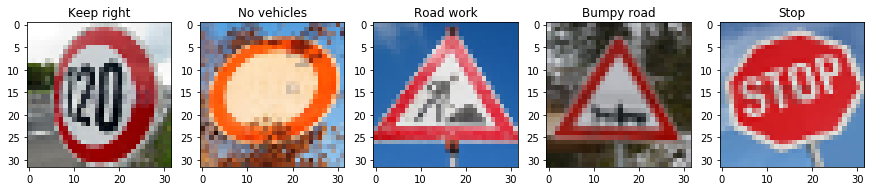

In [11]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

def load_sign_name_mapping(mapping_file_path):
    mapping = {}
    with open('signnames.csv', mode='r') as infile:
        reader = csv.reader(infile)
        for row in reader:
            if (row[0] == 'ClassId'):
                continue
            
            class_id = int(row[0])
            class_name = row[1]
            mapping[class_id] = class_name            
    return mapping


def display_prediction_result(mapping, predictions, images):
    num_images = len(images)
    num_columns = 5
    fig, axs = plt.subplots(nrows=1, ncols=num_columns, figsize=(15,15))
    index = 0
    for prediction, image in zip(predictions, images):
        row_index = int(index / num_columns)
        column_index = index % num_columns
        axs[column_index].set_title(mapping[prediction])
        axs[column_index].imshow(image)
        index += 1
    plt.show()
    
    
mapping = load_sign_name_mapping('./signnames.csv')
predictions = model.load_and_predict(normalized_images, model_save_file)
print('Predictions result is: {}'.format(predictions))

display_prediction_result(mapping, predictions, input_images)


### Analyze Performance

In [12]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
new_image_accuracy = 4/5
print('Accuracy for these 5 new images is: {}'.format(new_image_accuracy))

Accuracy for these 5 new images is: 0.8


INFO:tensorflow:Restoring parameters from ./deepnet/notebook-result
0: precision = 1.000, 60/60 Speed limit (20km/h)
1: precision = 0.984, 720/732 Speed limit (30km/h)
2: precision = 0.995, 747/751 Speed limit (50km/h)
3: precision = 1.000, 441/441 Speed limit (60km/h)
4: precision = 0.995, 648/651 Speed limit (70km/h)
5: precision = 0.990, 623/629 Speed limit (80km/h)
6: precision = 1.000, 148/148 End of speed limit (80km/h)
7: precision = 0.998, 449/450 Speed limit (100km/h)
8: precision = 0.998, 449/450 Speed limit (120km/h)
9: precision = 1.000, 480/480 No passing
10: precision = 1.000, 659/659 No passing for vehicles over 3.5 metric tons
11: precision = 0.952, 413/434 Right-of-way at the next intersection
12: precision = 0.997, 682/684 Priority road
13: precision = 0.997, 717/719 Yield
14: precision = 0.996, 270/271 Stop
15: precision = 1.000, 208/208 No vehicles
16: precision = 1.000, 150/150 Vehicles over 3.5 metric tons prohibited
17: precision = 0.997, 360/361 No entry
18: pre

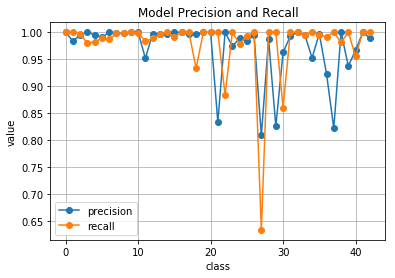

In [13]:
def calculate_model_precisions(sign_mapping, predictions, labels):
    precisions = []
    for label in range(0, n_classes):
        indices = np.where(predictions == label)
        class_prediction = np.take(predictions, indices)
        class_label = np.take(labels, indices)
        precision = np.sum(class_prediction == class_label) / class_prediction.shape[1]
        precisions.append(precision)
        print('{}: precision = {:.3f}, {}/{} {}'.format(label, precision, np.sum(class_prediction == class_label), class_prediction.shape[1], sign_mapping[label]))
    return precisions

def calculate_model_recall(sign_mapping, predictions, labels):
    recalls = []
    for label in range(0, n_classes):
        indices = np.where(labels == label)
        class_predictions = np.take(predictions, indices)
        class_labels = np.take(labels, indices)
        recall = np.sum(class_predictions == class_labels) / class_predictions.shape[1]
        recalls.append(recall)
        print('{}: recall = {:.3f}, {}/{} {}'.format(label, recall, np.sum(class_predictions == class_labels), class_predictions.shape[1], sign_mapping[label]))
    return recalls
    
def plot_model_precision_and_recall(precisions, recalls):
    classes = range(0, n_classes)        
    plt.figure()
    plt.title('Model Precision and Recall')
    plt.xlabel('class')
    plt.ylabel('value')
    plt.grid()
    plt.plot(classes, precisions, 'o-', label='precision')
    plt.plot(classes, recalls, 'o-', label='recall')
    plt.legend(loc='best')
    plt.show()

testing_predictions = model.load_and_predict(X_test, './deepnet/notebook-result')
precisions = calculate_model_precisions(mapping, testing_predictions, y_test)
recalls = calculate_model_recall(mapping, testing_predictions, y_test)
plot_model_precision_and_recall(precisions, recalls)

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

INFO:tensorflow:Restoring parameters from ./result/deepnet


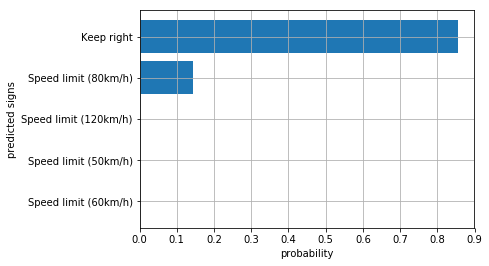

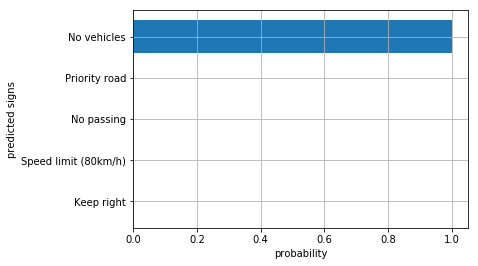

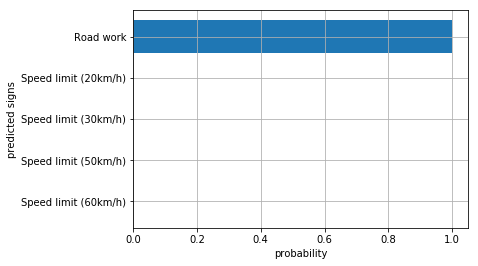

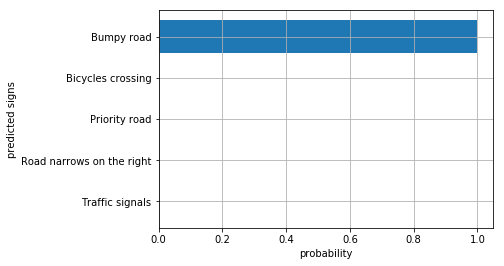

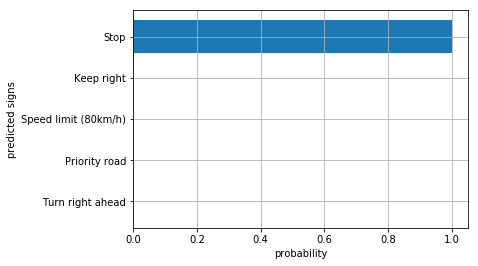

Image 1 prediction [38  5  8  2  3] with prob [  8.56790960e-01   1.42957926e-01   1.28699408e-04   9.93597132e-05
   1.07096657e-05]
Image 2 prediction [15 12  9  5 38] with prob [  1.00000000e+00   1.53789692e-08   7.43114059e-09   8.34574632e-11
   6.48949020e-11]
Image 3 prediction [25  0  1  2  3] with prob [ 1.  0.  0.  0.  0.]
Image 4 prediction [22 29 12 24 26] with prob [  1.00000000e+00   2.96916935e-10   2.70679257e-10   1.14384752e-11
   6.03536914e-13]
Image 5 prediction [14 38  5 12 33] with prob [  1.00000000e+00   1.86987812e-08   3.80301818e-10   2.35278352e-10
   8.83502854e-11]


In [14]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
def print_top_predictions(top5_predictions):
    index = 1
    for probablities, indices in zip(top5_predictions.values, top5_predictions.indices):
        print('Image {} prediction {} with prob {}'.format(index, indices, probablities))
        index += 1


def plot_top_predictions(top5_predictions):
    for probablities, indices in zip(top5_predictions.values, top5_predictions.indices):
        predicted_signs = []
        for index in indices:
            predicted_signs.append(mapping[index])

        num_values = len(probablities)
        ranks = range(1, num_values + 1)

        plt.barh(ranks,probablities, align='center')
        plt.yticks(ranks, predicted_signs)
        plt.xlabel('probability')
        plt.ylabel('predicted signs')
        plt.gca().invert_yaxis()
        plt.grid()
        plt.show()
    
    
top5_predictions = model.load_and_predict_top5(normalized_images, model_save_file)
plot_top_predictions(top5_predictions)
print_top_predictions(top5_predictions)

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


feature maps for convolution layer 1
INFO:tensorflow:Restoring parameters from ./result/deepnet


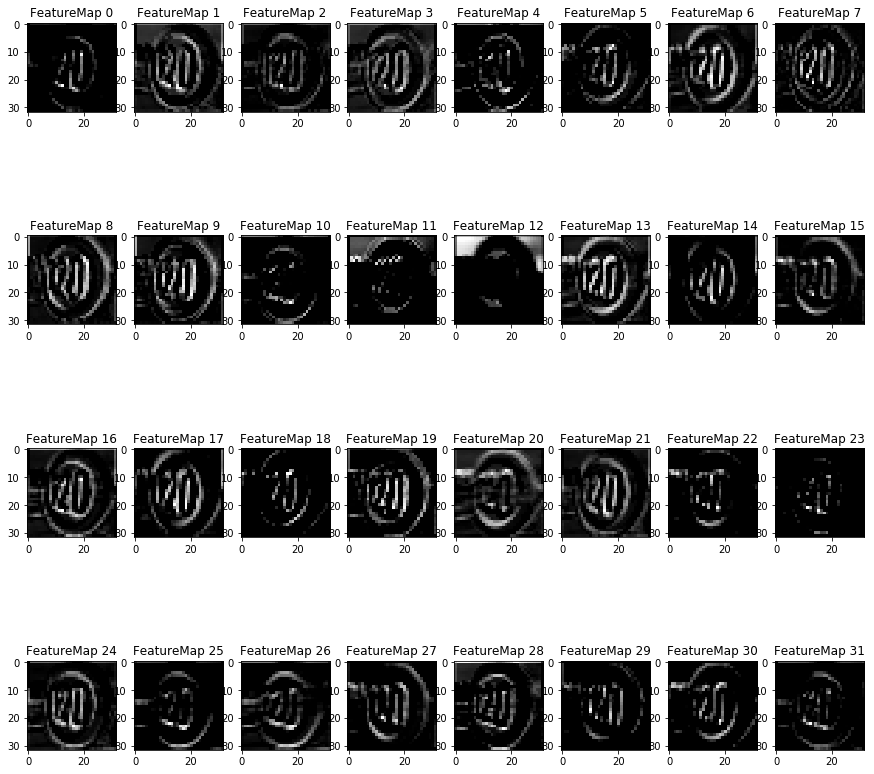

feature maps for convolution layer 2
INFO:tensorflow:Restoring parameters from ./result/deepnet


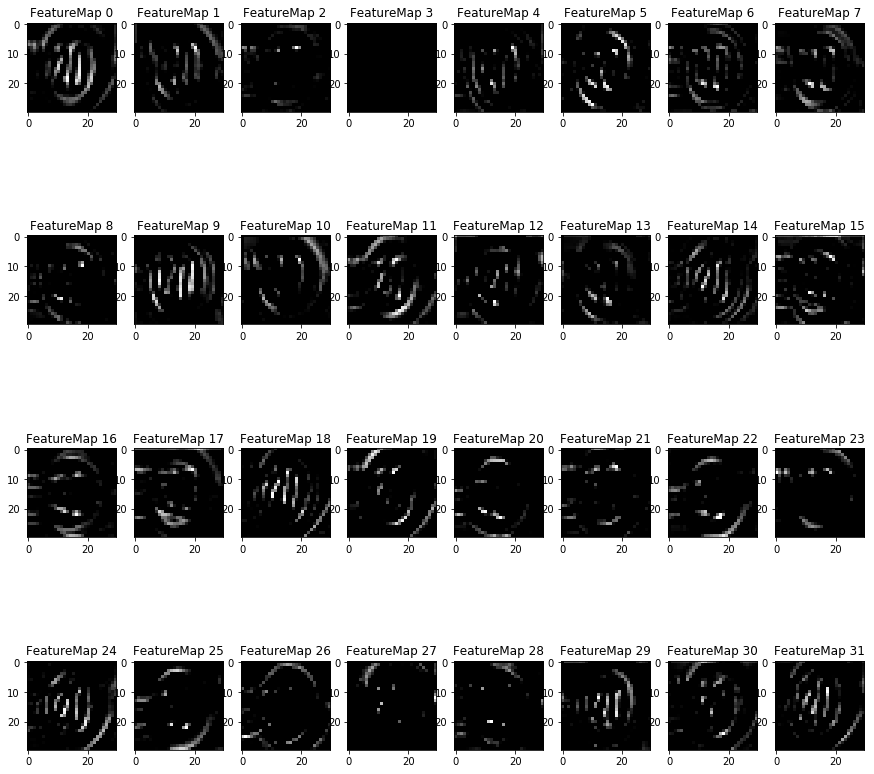

feature maps for convolution layer 3
INFO:tensorflow:Restoring parameters from ./result/deepnet


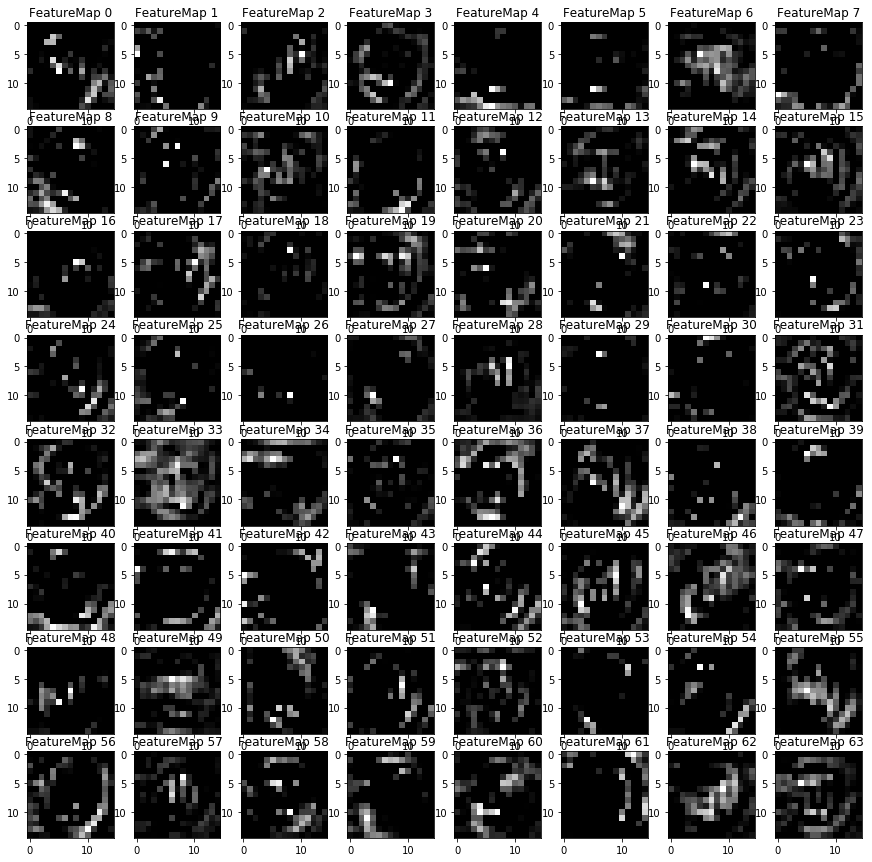

feature maps for convolution layer 4
INFO:tensorflow:Restoring parameters from ./result/deepnet


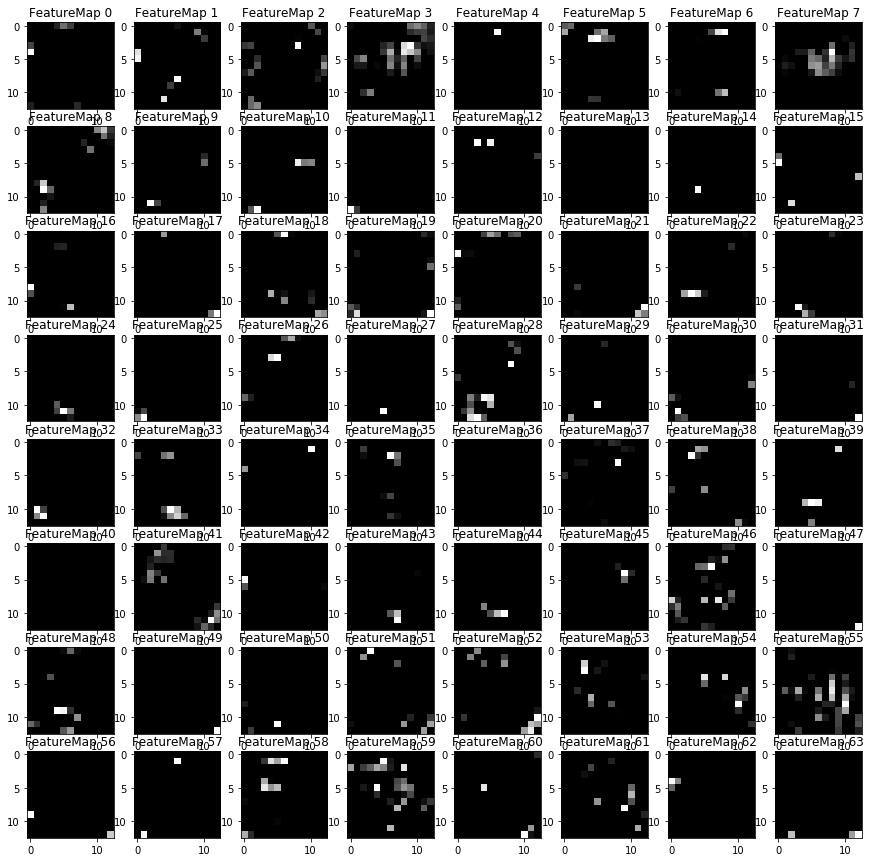

feature maps for convolution layer 5
INFO:tensorflow:Restoring parameters from ./result/deepnet


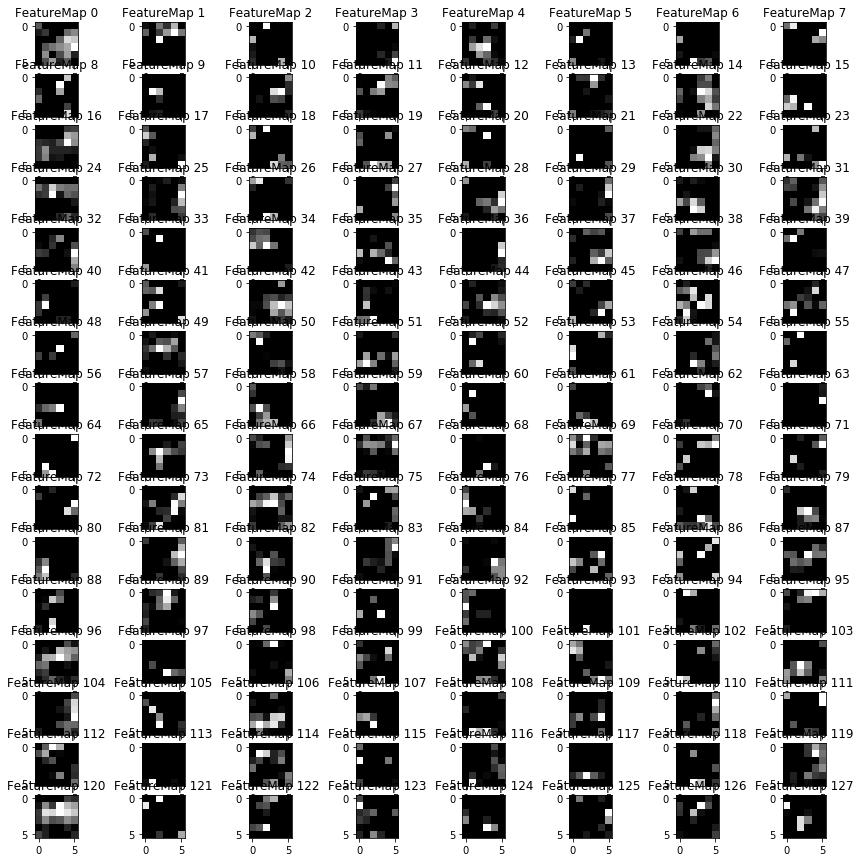

feature maps for convolution layer 6
INFO:tensorflow:Restoring parameters from ./result/deepnet


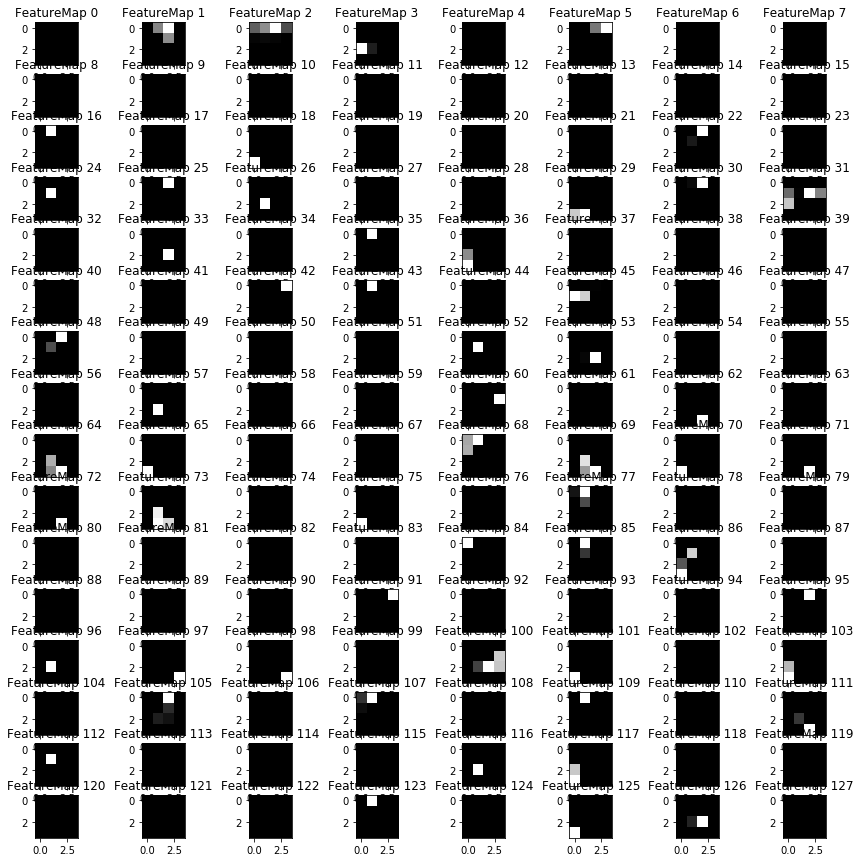

In [15]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.
print('feature maps for convolution layer 1')
model.load_and_visualize([normalized_images[0]], model_save_file, 'conv1')
print('feature maps for convolution layer 2')
model.load_and_visualize([normalized_images[0]], model_save_file, 'conv2')
print('feature maps for convolution layer 3')
model.load_and_visualize([normalized_images[0]], model_save_file, 'conv3')
print('feature maps for convolution layer 4')
model.load_and_visualize([normalized_images[0]], model_save_file, 'conv4')
print('feature maps for convolution layer 5')
model.load_and_visualize([normalized_images[0]], model_save_file, 'conv5')
print('feature maps for convolution layer 6')
model.load_and_visualize([normalized_images[0]], model_save_file, 'conv6')